<a href="https://colab.research.google.com/github/luisERH/tcc/blob/main/redes_neurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np 
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk 
import string

import tensorflow as tf
from keras.preprocessing.text import text_to_word_sequence
from sklearn.neural_network import MLPClassifier
from nltk.tokenize import word_tokenize
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import (Dense,
                                            Bidirectional,
                                            GlobalMaxPool1D,
                                            Embedding, 
                                            LSTM, 
                                            Dropout,
                                            BatchNormalization)

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, recall_score,precision_score
from sklearn.naive_bayes import MultinomialNB

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout,Bidirectional,Flatten
from keras.initializers import Constant
from keras.optimizers import Adam

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')

stemmer = SnowballStemmer("english")
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
plt.rcParams['figure.dpi'] = 200
pd.options.display.max_colwidth = 100

sucupira = pd.read_csv('/content/drive/MyDrive/TADS/TCC/dados.csv')[['ISSN','TITULO','AREA','QUALIS']]
display(sucupira.shape,sucupira.head())

(105304, 4)

,ISSN,TITULO,AREA,QUALIS
0,0003-6846,Applied Economics (Print),"ADMINISTRAÇÃO, CIÊNCIAS CONTÁBEIS E TURISMO",A1
1,0010-4655,Computer Physics Communications,"ADMINISTRAÇÃO, CIÊNCIAS CONTÁBEIS E TURISMO",A1
2,0013-0133,Economic Journal (London. Print),"ADMINISTRAÇÃO, CIÊNCIAS CONTÁBEIS E TURISMO",A1
3,0016-0032,Journal of the Franklin Institute,"ADMINISTRAÇÃO, CIÊNCIAS CONTÁBEIS E TURISMO",A1
4,0016-7185,Geoforum,"ADMINISTRAÇÃO, CIÊNCIAS CONTÁBEIS E TURISMO",A1


In [6]:
arxiv = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TCC/arxiv-issn.xlsx',index_col='issn')
arxiv = arxiv.rename({'abstract':'texto','journal-ref':'revista'},axis=1)[['texto','revista']]
arxiv = arxiv[arxiv.revista.apply(lambda x: not x.isspace())]
print(arxiv.shape)
arxiv.head()

(32374, 2)


,texto,revista
issn,,
1050-2947,We report the experimental realization and tomographic analysis of novel\nquantum light states...,PHYSICAL REVIEW A
0010-2180,The structure of three laminar premixed rich flames has been investigated: a\npure methane fla...,COMBUSTION AND FLAME
1079-7114,We study theoretically the properties of two Bose-Einstein condensates in\ndifferent spin stat...,PHYSICAL REVIEW LETTERS
0002-9890,We study the notion of Fagnano orbits for dual polygonal billiards. We used\nthem to character...,THE AMERICAN MATHEMATICAL MONTHLY
0003-6951,Graphene nano-ribbons junctions based electronic devices are proposed in this\nLetter. Non-equ...,APPLIED PHYSICS LETTERS


In [7]:
base = pd.merge(arxiv, sucupira.set_index('ISSN'), left_index=True, right_index=True).reset_index()
base = base[base.revista.apply(lambda x: not x.isspace())]
base.drop(['revista'],axis = 1, inplace = True)
base.rename({'texto':"ABSTRACT","index":'ISSN'},axis=1, inplace= True)
base = base[['ISSN','TITULO','ABSTRACT']].drop_duplicates()
print(base.shape)
base.head()

(32373, 3)


,ISSN,TITULO,ABSTRACT
0,0001-0782,Communications of the ACM,In this paper we discuss the impact of open source on both the security and\ntransparency of a...
3,0001-0782,Communications of the ACM,The Turing test aimed to recognize the behavior of a human from that of a\ncomputer algorithm....
6,0001-0782,Communications of the ACM,The ongoing debate on the ethics of self-driving cars typically focuses on\ntwo approaches to ...
9,0001-0782,Communications of the ACM,"On the morning of November 9th 2016, the world woke up to the shocking\noutcome of the US Pres..."
12,0001-1541,AIChE Journal,"In this paper, we develop a method for obtaining the approximate solution for\nthe evolution o..."


In [8]:
revistas_utilizadas = {'Applied Physics Letters',
 'Journal of Applied Physics',
 'Journal of Mathematical Physics',
 'Nature Communications',
 'Optics Express',
 'Optics Letters',
 'Physical Review C',
 'Physical Review Letters',
 'Physical Review. A',
 'Physics of Plasmas',
 'Scientific Reports',
 'Symmetry',
 'THE ASTROPHYSICAL JOURNAL',
 'The Journal of Chemical Physics',
 'Journal of Machine Learning Research'}
 
base = base[base.TITULO.apply(lambda x: x in revistas_utilizadas)]
sucupira = sucupira[['ISSN','TITULO','AREA','QUALIS']]

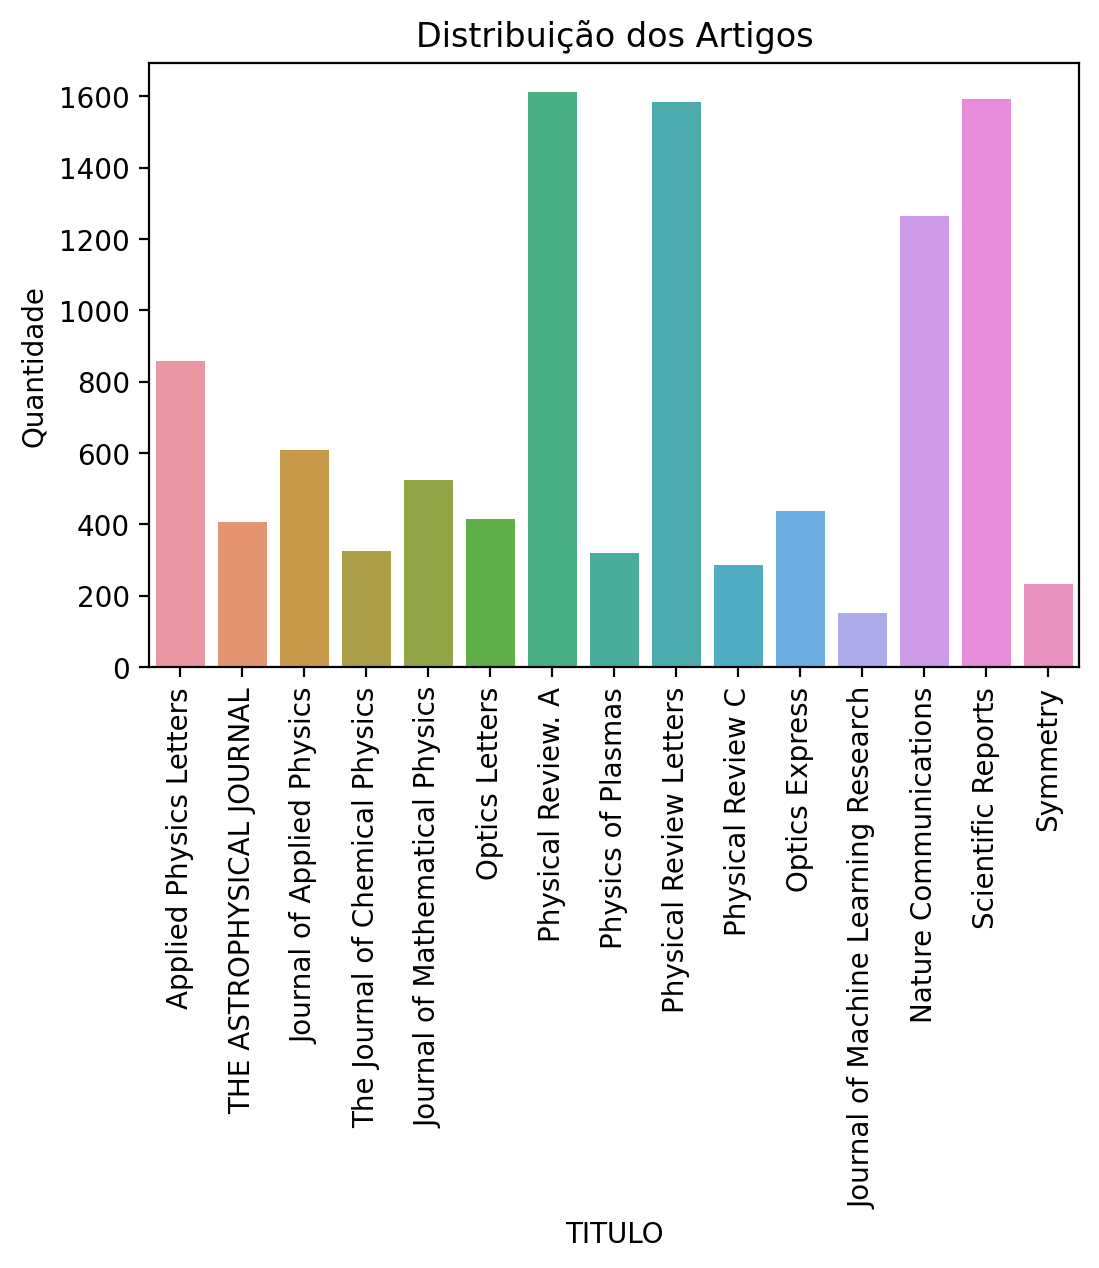

In [19]:
g = sns.countplot(x=base['TITULO'])
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_ylabel('Quantidade')
plt.title("Distribuição dos Artigos")
plt.savefig('dist_artigos.png')

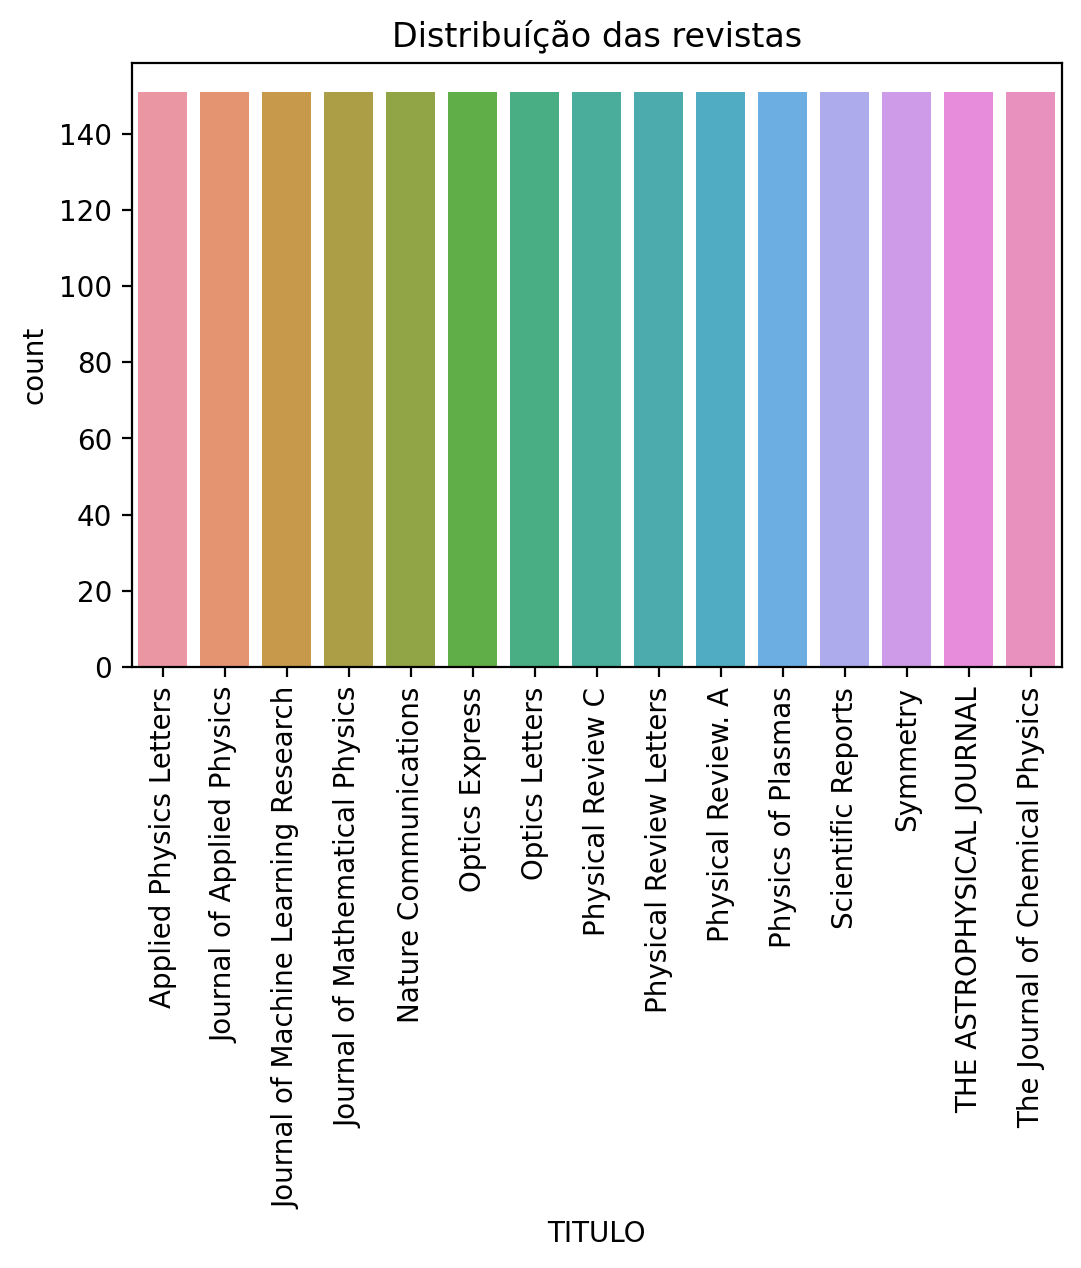

In [ ]:
def distribuir_classes(base):
    frames = []
    for i in np.unique(base.TITULO): #retorna nome das classes dessa coluna
        g = base[base.TITULO == i].sample(min(base.TITULO.value_counts())) # classe com menor quantidade de registros
        frames.append(g)

    base = pd.concat(frames) # base de dados distribuída igualmente
    g = sns.countplot(x = base['TITULO'])
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    plt.title("Distribuíção das revistas")
    return base

base = distribuir_classes(base)

In [ ]:
def basic_text_preprocessing(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', '!"#$\;?.,@_|~`'))
    text = nltk.word_tokenize(text)
    text = list(filter(lambda x: x != "" ,[elem if elem not in stop_words else '' for elem in text]))
    text = list(map( stemmer.stem,text ))
    return " ".join(text)

# text = "In both doped flames, 2.49% of C3H4 was added, corresponding to a ratio C3H4/CH4 of 12% and an equivalence ratio of 1.55."
# basic_text_preprocessing(text)

In [ ]:
# Matriz de confusão
def plot_cm(y_true, y_pred, name_model, figsize=(12,12)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Classes'
    cm.columns.name = 'Predições'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(f'Matriz de confusão para o modelo {name_model}')
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax,)
    plt.savefig(f'/content/drive/My Drive/Colab Notebooks/TCC/cm-{name_model}.png',dpi=400)


def plot_graphs(history, string):
    plt.plot(hist_lstm.history[string],marker="v",ls='-')
    plt.plot(hist_lstm.history['val_'+string],marker="v",ls='dotted')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.savefig(f'/content/drive/My Drive/Colab Notebooks/TCC/{string}-blstm.png')
    plt.show()
  

In [ ]:
def treinar(base, modelo,vectorizer):
    X_train, X_val, y_train, y_val = train_test_split(base.ABSTRACT.apply(lambda x: x.lower()), base.TITULO, test_size=0.3)
    # Get the training vectors
    vectors = vectorizer.fit_transform(X_train)

    # Build the classifier
    model =  MLPClassifier(hidden_layer_sizes=(100,100),
                           solver='adam',
                           learning_rate_init=0.0001,
                           max_iter=200,
                           learning_rate ='adaptive',
                           random_state=1,
                           verbose=False)

    #  Train the classifier
    model.fit(vectors, y_train)

    # Get the test vectors
    vectors_test = vectorizer.transform(X_val)

    # Predict and score the vectors
    pred = model.predict(vectors_test)
    acc_score = accuracy_score(y_val, pred)
    recall = recall_score(y_val, pred,average='macro')
    precision = precision_score(y_val, pred,average='macro')
    f1 = f1_score(y_val, pred, average='macro')

    print(f'Accuracy score for MLP: {acc_score}')
    print(f'Recall score for MLP: {recall}')
    print(f'precision score for MLP: {precision}')
    print(f'F1 score for MLP: {f1}')

    plot_cm(y_val, pred, modelo )

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy score for MLP: 0.575
Recall score for MLP: 0.5871018994142605
precision score for MLP: 0.5796403459930272
F1 score for MLP: 0.5789245497200579


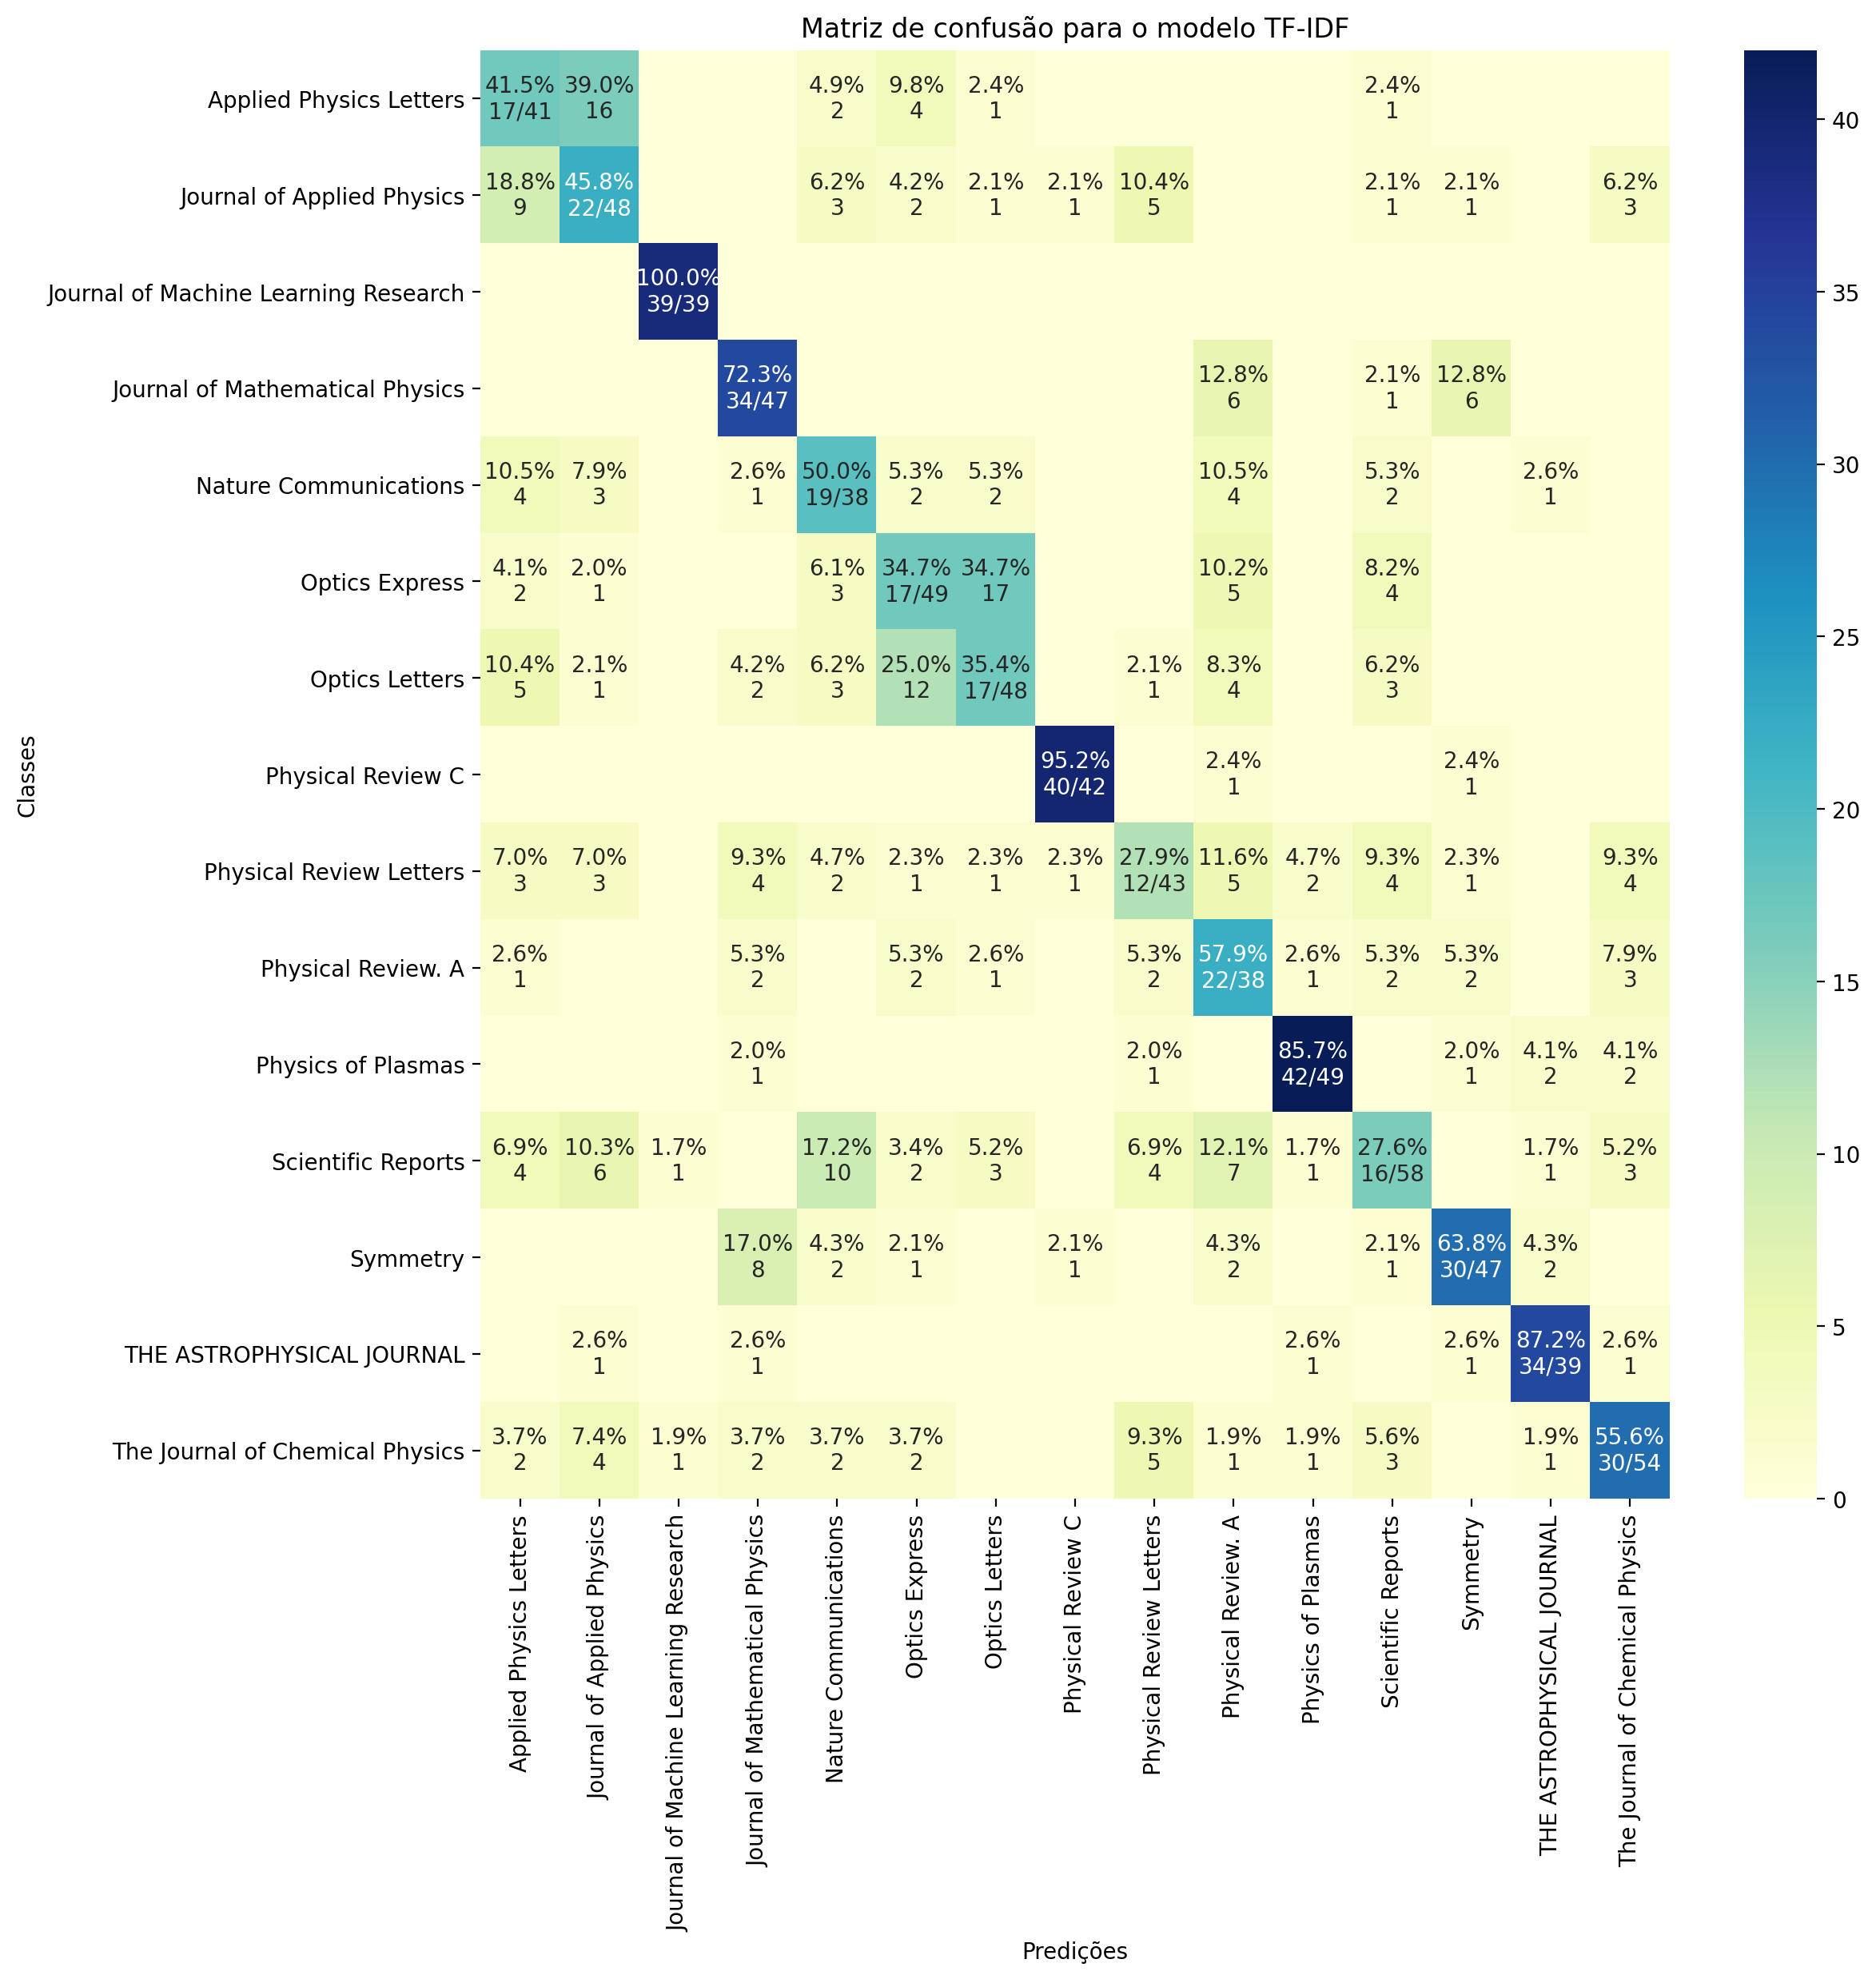

In [ ]:
# criando classificador TF-IDF
vectorizer = TfidfVectorizer(dtype=np.float32,
                             min_df=3,
                             max_features=None,
                             strip_accents='unicode',
                             analyzer='word',
                             token_pattern=r'\w{1,}',
                             ngram_range=(1, 3),
                             use_idf=1,
                             smooth_idf=1,
                             sublinear_tf=1,
                             preprocessor = basic_text_preprocessing)
 
treinar(base, 'TF-IDF',vectorizer)

Accuracy score for MLP: 0.5294117647058824
Recall score for MLP: 0.5240143775517446
precision score for MLP: 0.5297085267797458
F1 score for MLP: 0.5228369243551737


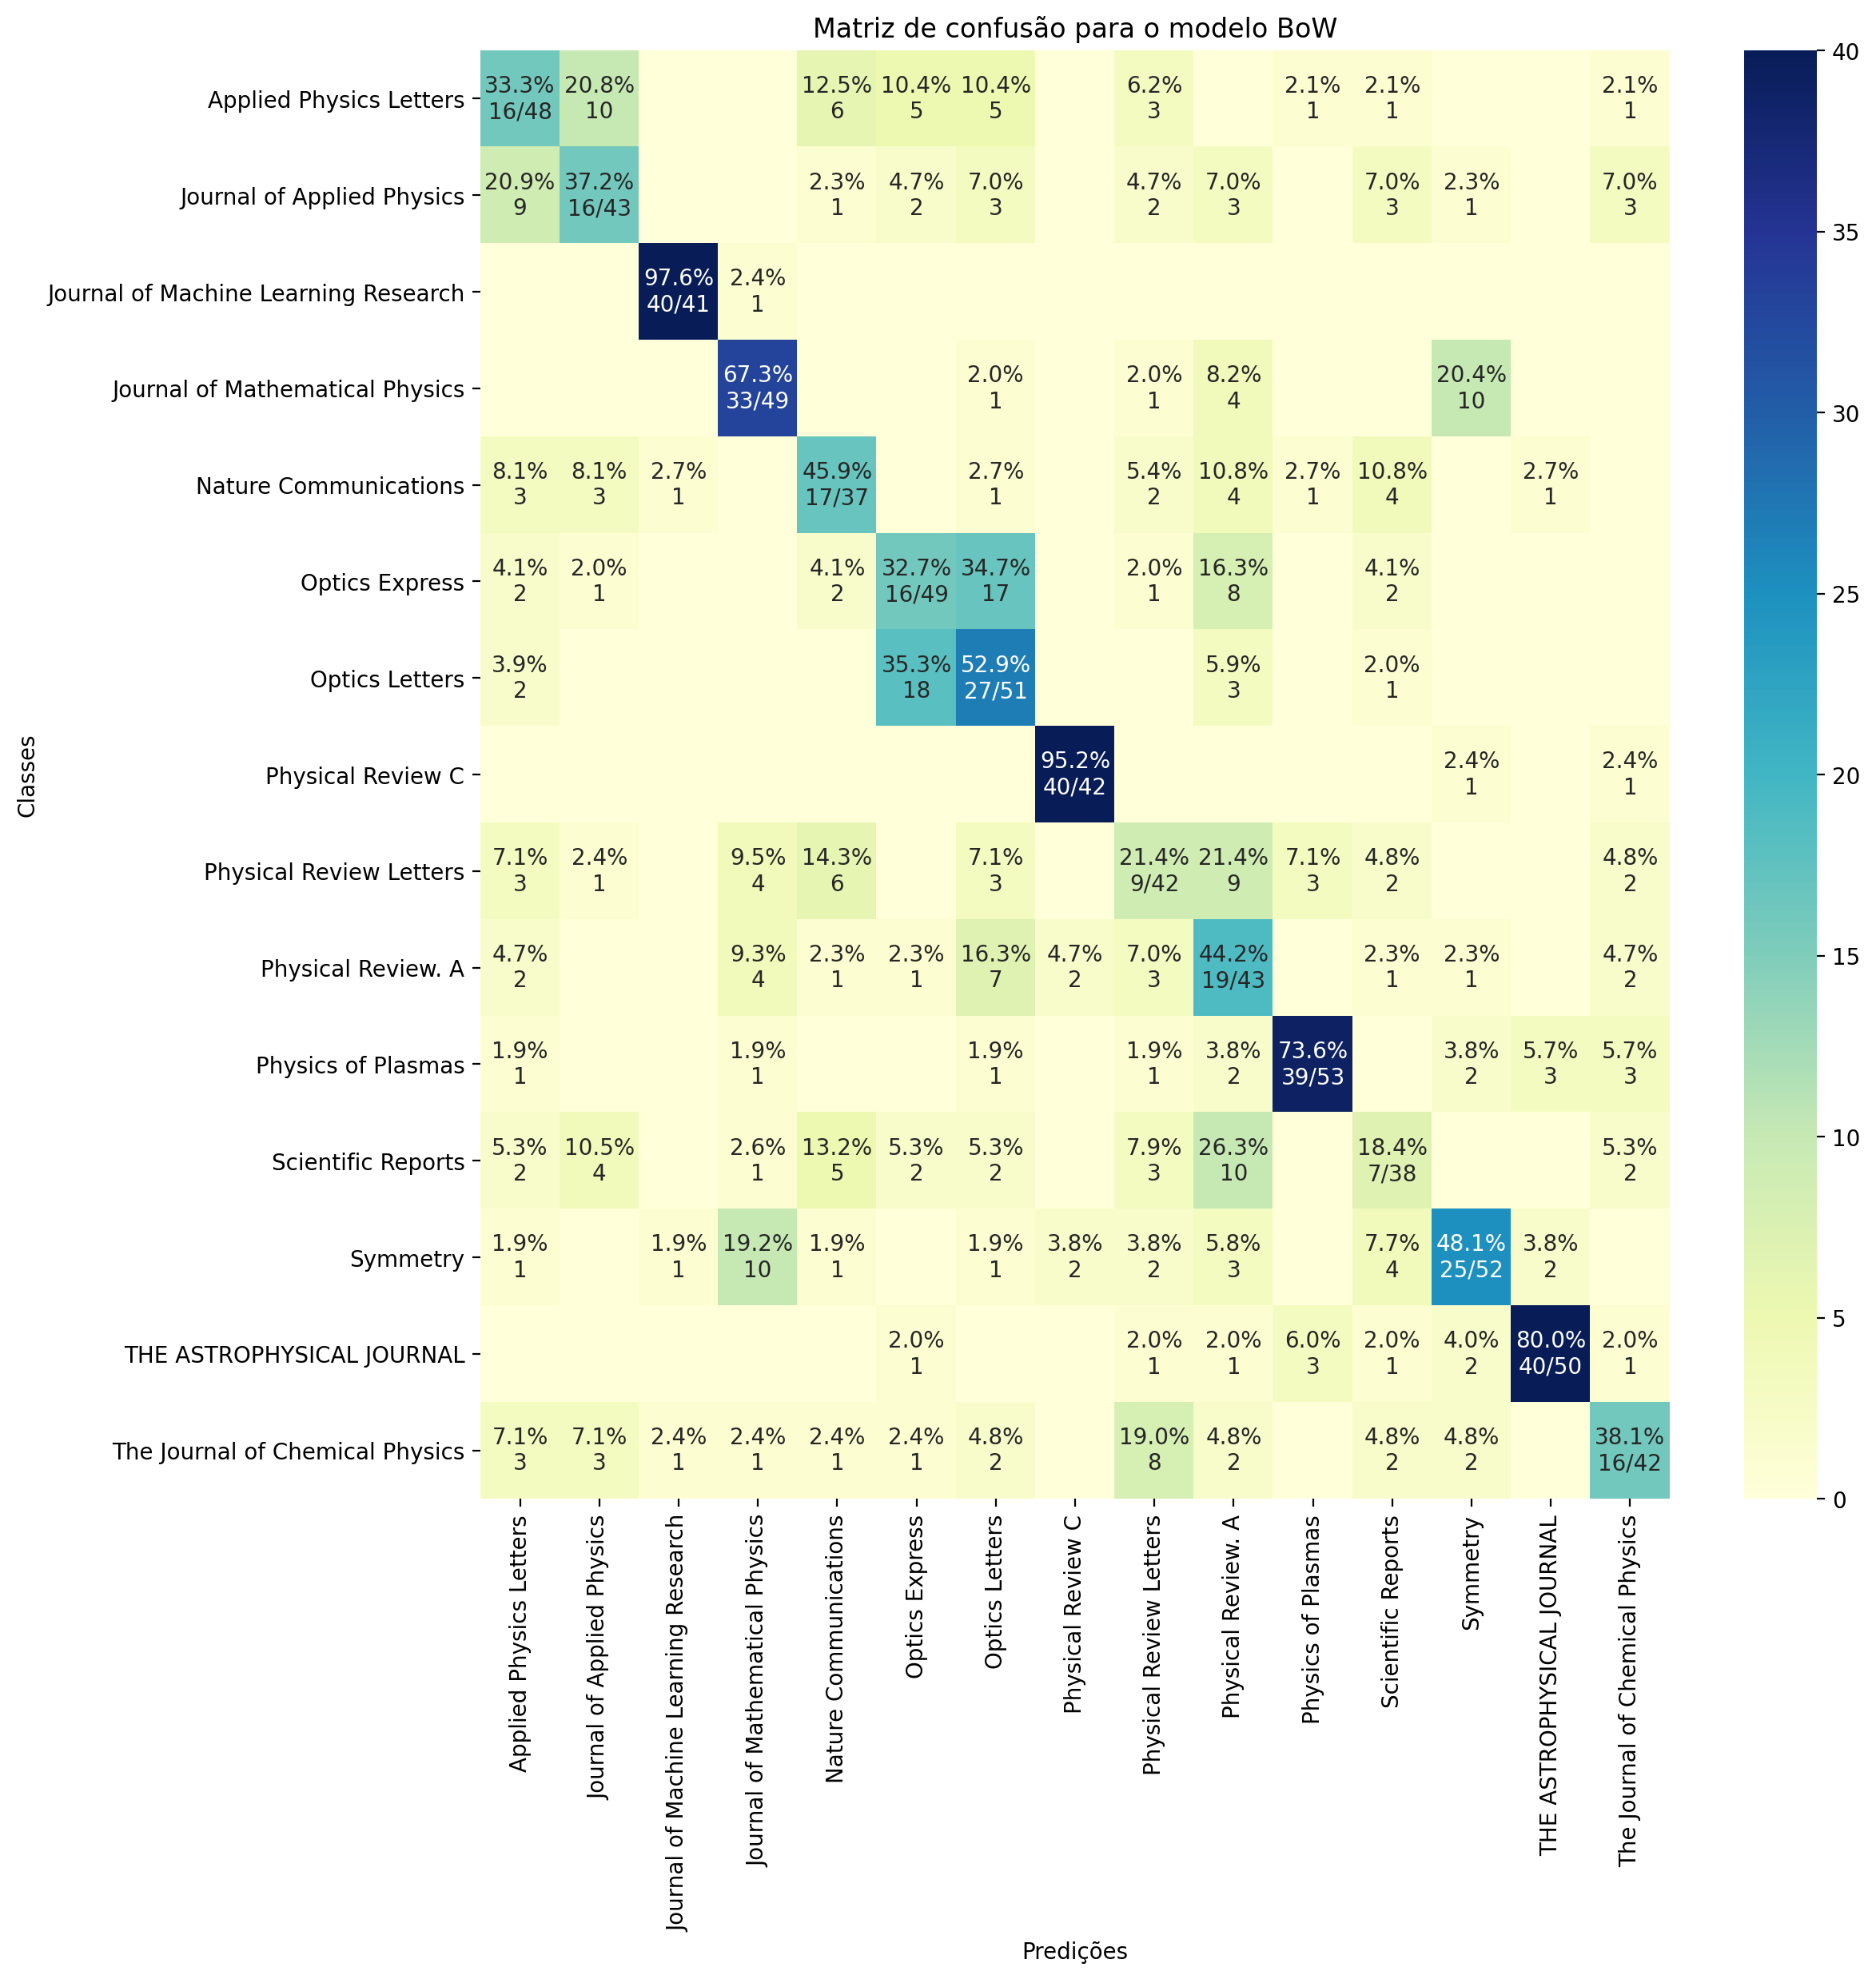

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
treinar(base, 'BoW',vectorizer)

* **Tokenizer:** para pré-processar os dados de texto
* **pad_sequences:** para garantir que os dados do texto final tenham o mesmo comprimento
* **sequential:** para inicializar as camadas
* **Dense:** para criar a rede neural totalmente conectada
* **LSTM** usado para criar a camada LSTM
* **Bidirectional:** para garantir que a informação seja passada em ambas as direções
* **Pandas:** para carregar no arquivo de texto
* **numpy:** irá converter os dados em matrizes NumPy

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip /content/glove.6B.zip -d ./

In [ ]:
from keras.preprocessing.text import Tokenizer
from  tqdm import tqdm

In [ ]:
enc = LabelEncoder()
base.TITULO = enc.fit_transform(base['TITULO'])
X_train, X_test, y_train, y_test = train_test_split(base.ABSTRACT, base.TITULO, test_size=0.3,random_state = 95)

In [ ]:

def load_glove_index(embed_dim):
    EMBEDDING_FILE =f'/content/glove.6B.{embed_dim}d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:embed_dim]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    return embeddings_index
embed_dim = 100
glove_embedding_index = load_glove_index(embed_dim)

In [ ]:
max_features = 30811
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train.to_list()+X_test.to_list())
train_X = tokenizer.texts_to_sequences(X_train)
test_X = tokenizer.texts_to_sequences(X_test)

In [ ]:
train_X = pad_sequences(train_X, maxlen=base.ABSTRACT.apply(lambda x: len(x)).max()+1)
test_X = pad_sequences(test_X, maxlen=base.ABSTRACT.apply(lambda x: len(x)).max()+1)

In [ ]:
def create_glove(word_index,embeddings_index):
    emb_mean,emb_std = -0.005838499,0.48782197
    all_embs = np.stack(embeddings_index.values())
    embed_size = all_embs.shape[1]
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    count_found = nb_words
    for word, i in tqdm(word_index.items()):
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] =  embedding_vector
        else:
                count_found-=1
    print("Got embedding for ",count_found," words.")
    return embedding_matrix   

matrix =create_glove(tokenizer.word_index,glove_embedding_index)  

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 30811/30811 [00:00<00:00, 545212.80it/s]

Got embedding for  21304  words.


In [ ]:
# Prepare labels for categorical prediction
print(np.unique(y_train))
categorical_y_train = to_categorical(y_train, num_classes=len(revistas_utilizadas)+1, dtype='float32')
categorical_y_test = to_categorical(y_test, num_classes=len(revistas_utilizadas)+1, dtype='float32')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(30811, embed_dim,weights=[matrix], input_length=base.ABSTRACT.apply(lambda x: len(x)).max()+1,trainable=False,name='Embedding')) 
model_lstm.add(LSTM(embed_dim, return_sequences=True, name='LSTM',recurrent_dropout=0.1))
model_lstm.add(GlobalMaxPool1D(name='GlobalMaxPool1D'))
model_lstm.add(Dense(embed_dim, activation="relu",name='Dense_1'))
model_lstm.add(Dropout(0.1,name='Dropout'))
model_lstm.add(Dense(len(np.unique(y_train))+1, activation='softmax',name='Dense_2'))

model_lstm.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', 
              metrics=['accuracy'])



model_lstm.summary()
batch_size_lstm = 64
epochs_lstm = 10

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 2483, 100)         3081100   
_________________________________________________________________
LSTM (LSTM)                  (None, 2483, 100)         80400     
_________________________________________________________________
GlobalMaxPool1D (GlobalMaxPo (None, 100)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 16)                1616      
Total params: 3,173,216
Trainable params: 92,116
Non-trainable params: 3,081,100
_______________________________________

In [ ]:
hist_lstm =  model_lstm.fit(train_X, 
                              categorical_y_train, 
                              batch_size=batch_size_lstm, 
                              epochs=epochs_lstm, 
                              shuffle=True,
                              validation_data=(test_X, categorical_y_test))

Epoch 1/10
117/117 [==============================] - 474s 4s/step - loss: 2.4790 - accuracy: 0.1731 - val_loss: 2.1739 - val_accuracy: 0.2472
Epoch 2/10
117/117 [==============================] - 492s 4s/step - loss: 2.1205 - accuracy: 0.2813 - val_loss: 2.0861 - val_accuracy: 0.2735
Epoch 3/10
117/117 [==============================] - 498s 4s/step - loss: 1.8984 - accuracy: 0.3436 - val_loss: 1.8134 - val_accuracy: 0.3588
Epoch 4/10
117/117 [==============================] - 495s 4s/step - loss: 1.7060 - accuracy: 0.4109 - val_loss: 1.7397 - val_accuracy: 0.3748
Epoch 5/10
117/117 [==============================] - 491s 4s/step - loss: 1.5876 - accuracy: 0.4447 - val_loss: 1.6946 - val_accuracy: 0.4090
Epoch 6/10
117/117 [==============================] - 487s 4s/step - loss: 1.4848 - accuracy: 0.4825 - val_loss: 1.6059 - val_accuracy: 0.4529
Epoch 7/10
117/117 [==============================] - 489s 4s/step - loss: 1.4350 - accuracy: 0.4989 - val_loss: 1.6128 - val_accuracy: 0.4197

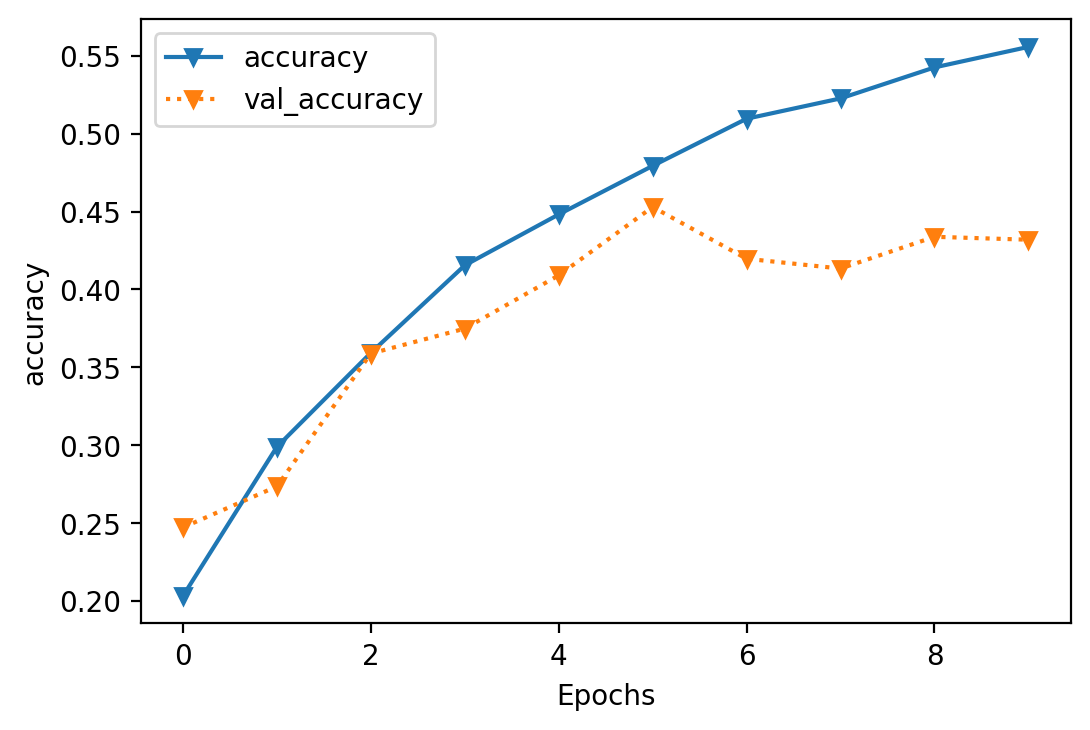

In [ ]:
plot_graphs(hist_lstm, "accuracy")

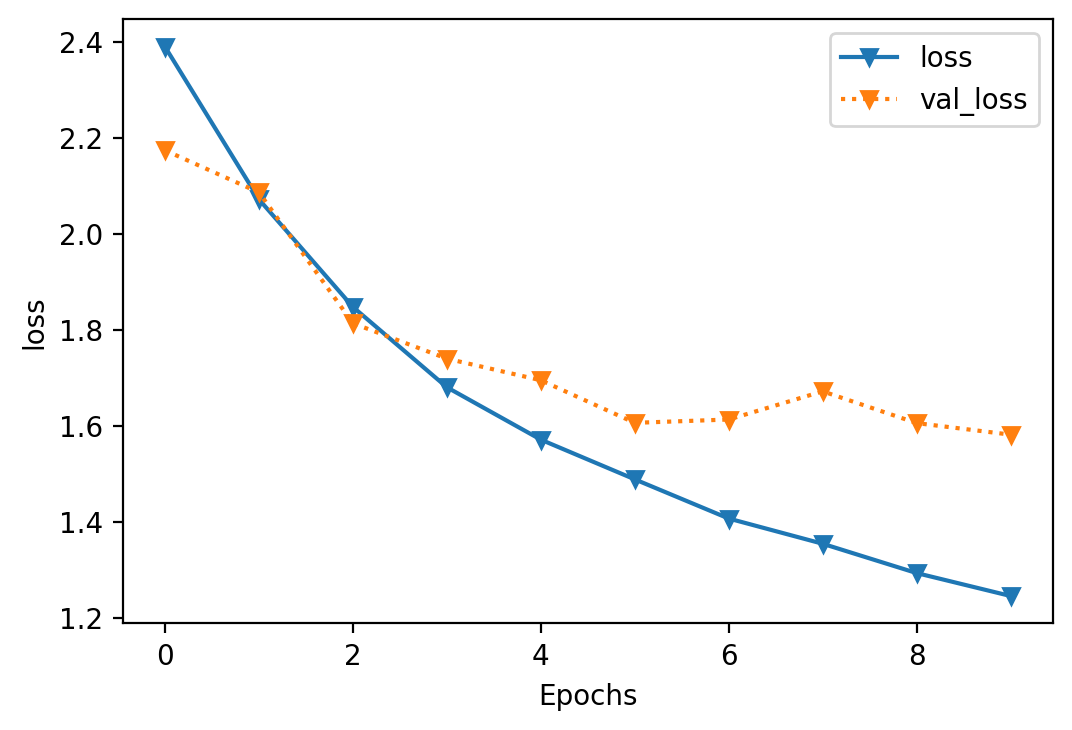

In [ ]:
plot_graphs(hist_lstm, "loss")

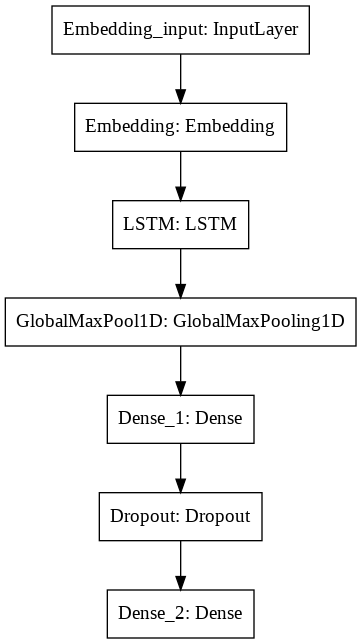

In [ ]:
plot_model(model_lstm, to_file='/content/drive/My Drive/Colab Notebooks/TCC/multiclass-lstm.png')

In [ ]:
loss_lstm, acc_lstm = model_lstm.evaluate(test_X, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_lstm*100))

y_pred_lstm =np.argmax(model_lstm.predict(test_X), axis=-1)

y_test_label = []
for counter in range(0, len(categorical_y_test)):
  label = np.argmax(categorical_y_test[:][counter])
  y_test_label.append(label)
y_test_label = np.array(y_test_label)

#[print(j) for j in dict(zip([i for i in range(7)], enc.inverse_transform(range(7)))).items()]
y_test_label = enc.inverse_transform(y_test_label)
y_pred_lstm = enc.inverse_transform(y_pred_lstm)


Test Accuracy: 43.193224


In [ ]:
y_pred_lstm

array(['Scientific Reports', 'Scientific Reports', 'Physical Review C',
       ..., 'Scientific Reports', 'Journal of Mathematical Physics',
       'Applied Physics Letters'], dtype=object)

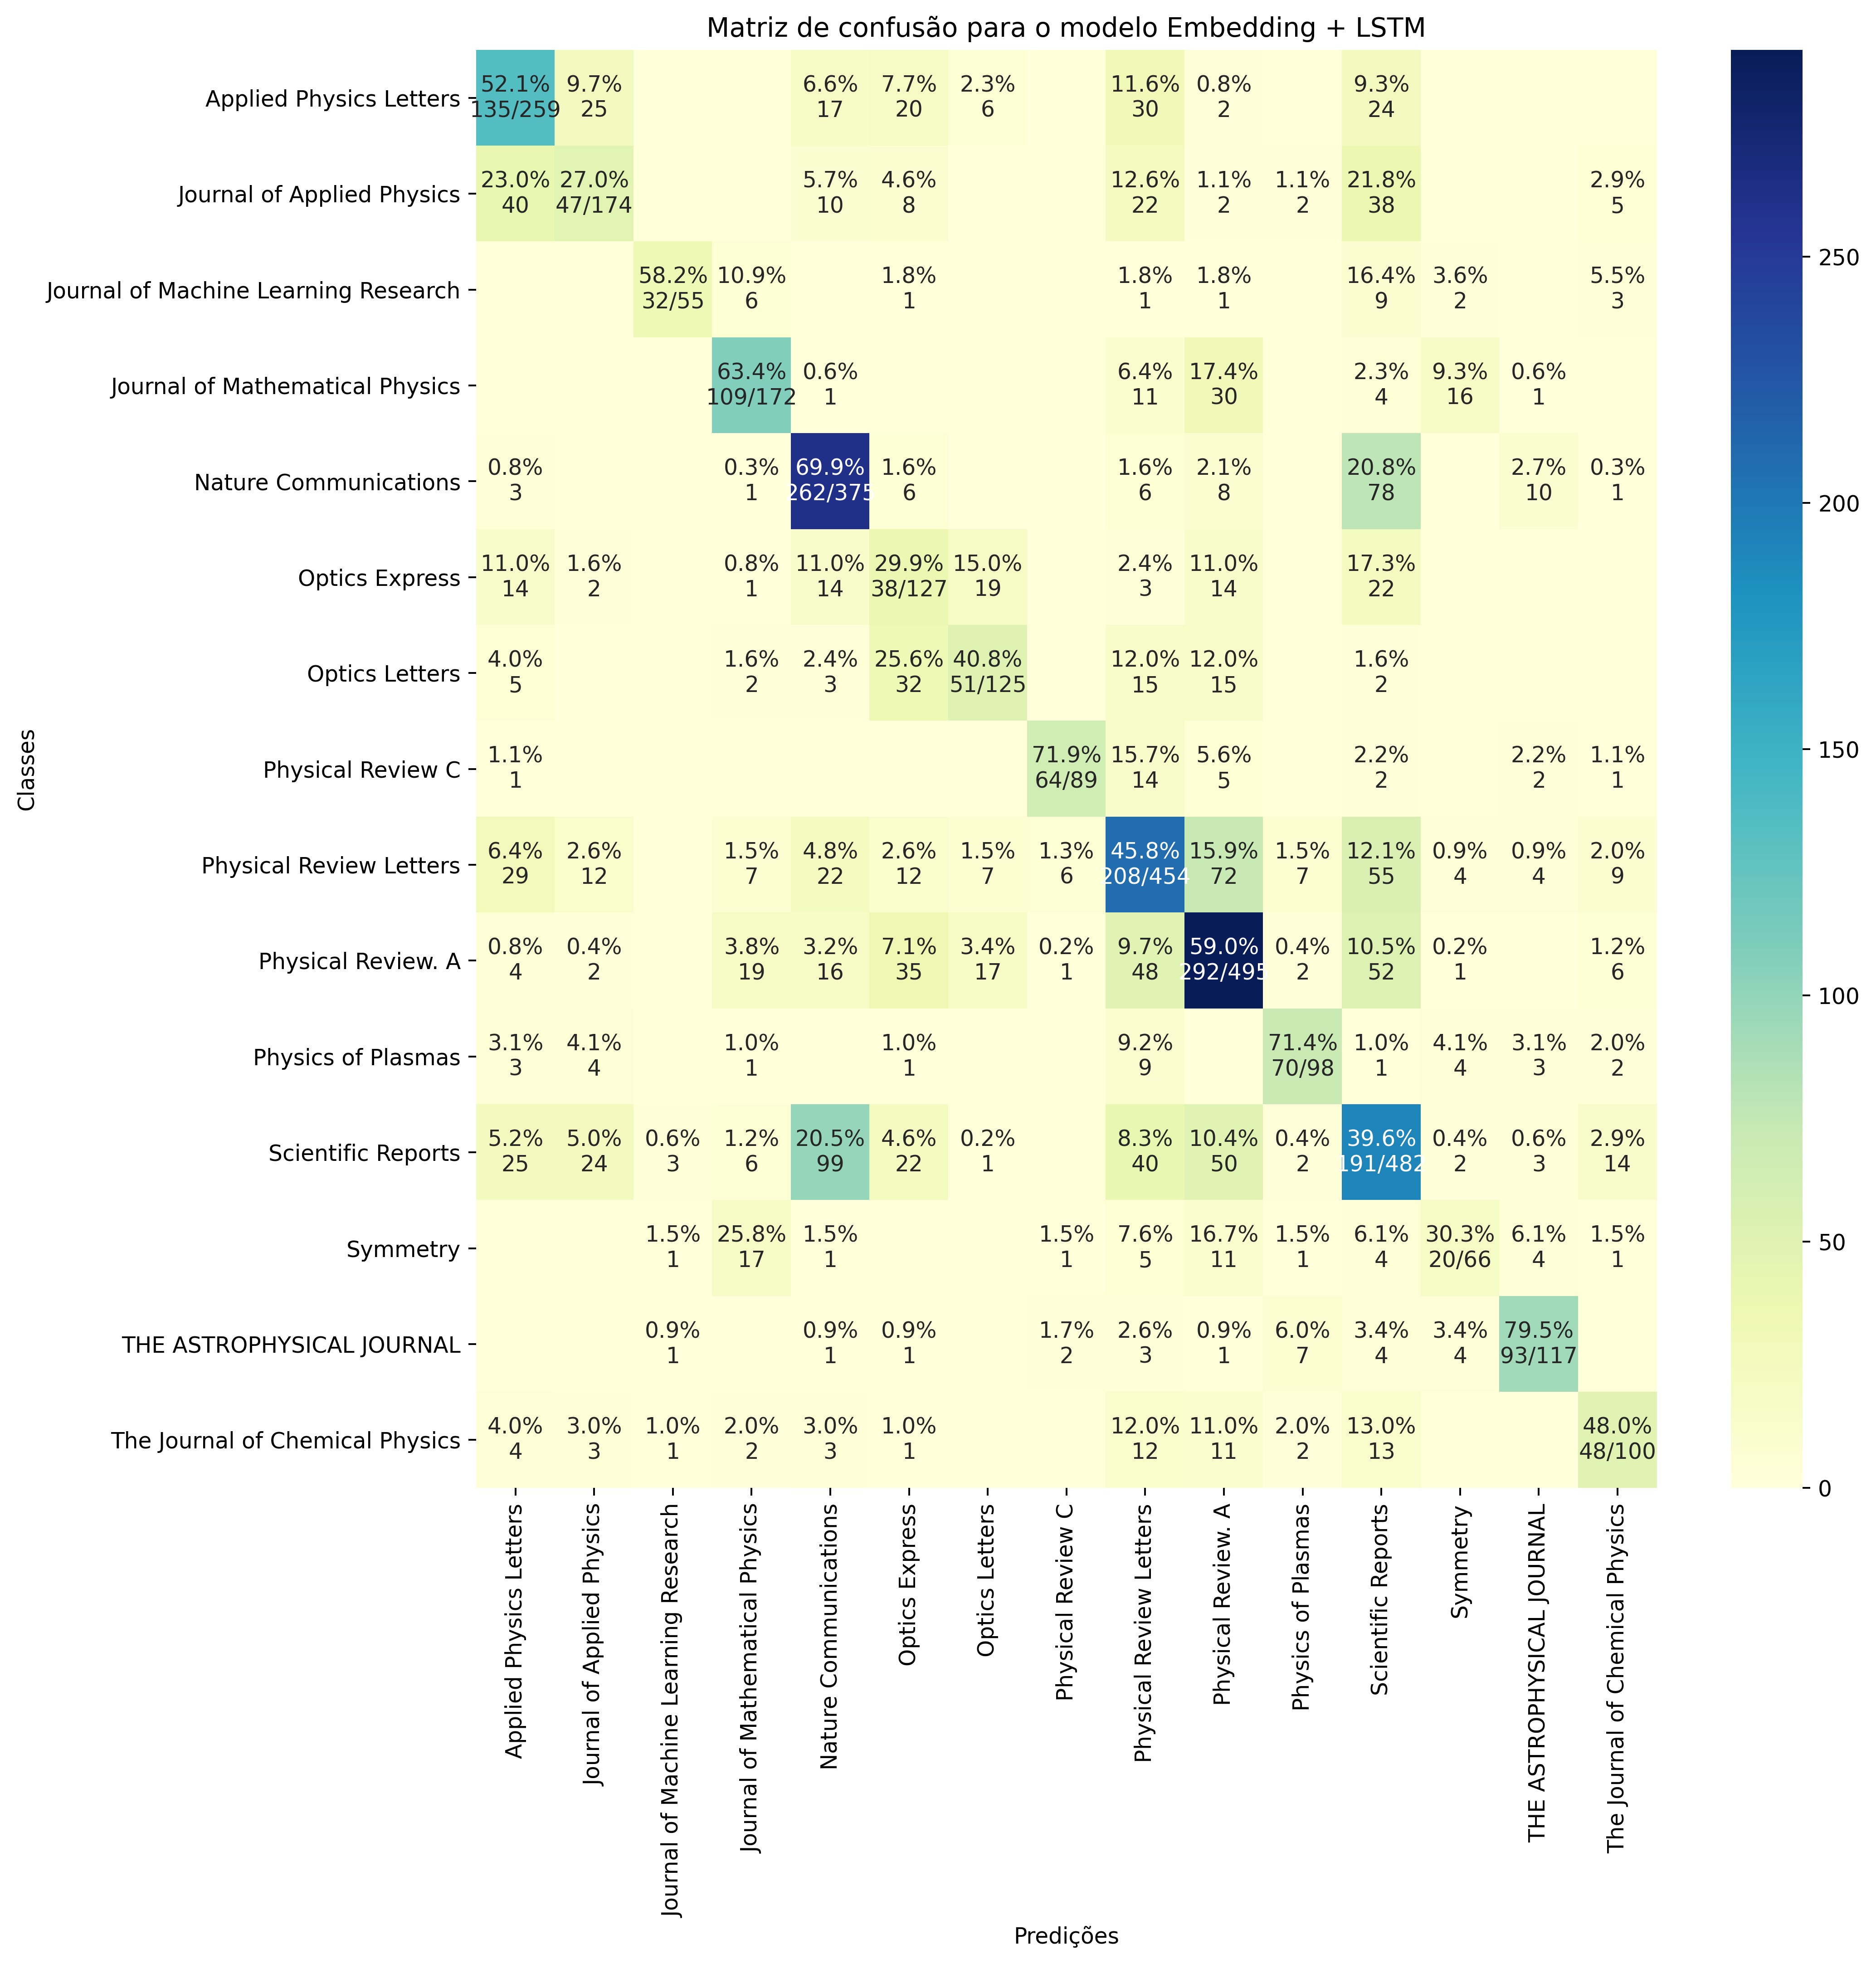

In [ ]:
plot_cm (y_pred,pred , 'Embedding + LSTM')